# > Imports

In [3]:
import json
import pandas as pd
import numpy as np
from datetime import datetime, timezone, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from dotenv import load_dotenv
import os

In [4]:
# Directory Paths
TS_DIR   = None
DATA_DIR = None

# Load directory paths from .env file
loaded = load_dotenv(dotenv_path="../expanse.env")
if loaded == True:
    TS_DIR   = os.environ['TS_DIR']
    DATA_DIR = os.environ['DATA_DIR']
    print(f"Loaded environment variables.")
else:
    print(f"Environment variables not loaded.")

Loaded environment variables.


# > Plots

## >> Load Traffic Stats

In [12]:
# 2003-11-06 -> 2023-04-04
START_STR_INPUT = '2003-11-06T00:00:00Z'
END_STR_INPUT = '2023-04-04T00:00:00Z'
END_STR_INPUT = '2023-04-04T00:00:00Z'

json_live_dir = f'{DATA_DIR}/nersc_inv/json/live'
start = datetime.strptime(START_STR_INPUT, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
end = datetime.strptime(END_STR_INPUT, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)

In [ ]:
%%time

# Daily Granualarity
file_entries = []

cur = start
while cur <= end:
    # Read in JSON object
    try:
        with open(fr'{json_live_dir}/{cur.strftime("%Y-%m-%d")}.json') as f:
            file_contents = f.read()
    except FileNotFoundError:
        print(fr'File not found for {cur}')
        # file_entries.append((cur, None, None))
        cur += relativedelta(days=1)
        continue
        
    json_obj = json.loads(file_contents)
    
    # print(len(json_obj['DATA']))
    
    for entry in json_obj['DATA']:
        name_prefix = entry['name'].split('.')[0]
        time = entry['name'].split('.')[1]
        size = entry['size']
        file_entries.append((time, name_prefix, size))
    
    # print(len(json_obj['DATA']))
    # print(json_obj['DATA'][0]['name'])
    # print(json_obj['DATA'][0]['name'].split('.')[1])
    # print(json_obj['DATA'][0]['size'])
    cur += relativedelta(days=1)

File not found for 2003-11-12 00:00:00+00:00
File not found for 2003-11-13 00:00:00+00:00
File not found for 2003-11-14 00:00:00+00:00
File not found for 2003-11-15 00:00:00+00:00
File not found for 2003-11-16 00:00:00+00:00
File not found for 2003-11-17 00:00:00+00:00
File not found for 2003-11-18 00:00:00+00:00
File not found for 2003-11-19 00:00:00+00:00
File not found for 2003-11-20 00:00:00+00:00
File not found for 2003-11-21 00:00:00+00:00
File not found for 2003-11-22 00:00:00+00:00
File not found for 2003-11-23 00:00:00+00:00
File not found for 2003-11-24 00:00:00+00:00
File not found for 2003-11-25 00:00:00+00:00
File not found for 2003-11-26 00:00:00+00:00
File not found for 2003-11-27 00:00:00+00:00
File not found for 2003-11-28 00:00:00+00:00
File not found for 2003-11-29 00:00:00+00:00
File not found for 2003-11-30 00:00:00+00:00
File not found for 2003-12-01 00:00:00+00:00
File not found for 2003-12-02 00:00:00+00:00
File not found for 2003-12-03 00:00:00+00:00
File not f

In [ ]:
df = pd.DataFrame(file_entries, columns=['timestamp', 'filename_prefix', 'filesize_B'])
df['filesize_GB'] = df['filesize_B'] / 1e9
df['filesize_TB'] = df['filesize_B'] / 1e12
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df = df.set_index('timestamp')

In [ ]:
df

## >> Daily Compressed PCAP Filesizes

In [7]:
# Hourly Averages per Month

# Daily File Sizes Aggregated per Month
# daily_max_fs = df.groupby('day').sum('filesize_GB').filesize_GB.resample('1M').max()
# daily_median_fs = df.groupby('day').sum('filesize_GB').filesize_GB.resample('1M').median()
# daily_25q_fs = df.groupby('day').sum('filesize_GB').filesize_GB.resample('1M').quantile(.25)
# daily_75q_fs = df.groupby('day').sum('filesize_GB').filesize_GB.resample('1M').quantile(.75)

daily_max_fs = df.groupby(pd.Grouper(freq='1D')).sum('filesize_TB').groupby(pd.Grouper(freq='1MS')).filesize_TB.max()
daily_median_fs = df.groupby(pd.Grouper(freq='1D')).sum('filesize_TB').groupby(pd.Grouper(freq='1MS')).filesize_TB.median()
daily_25q_fs = df.groupby(pd.Grouper(freq='1D')).sum('filesize_TB').groupby(pd.Grouper(freq='1MS')).filesize_TB.quantile(.25)
daily_75q_fs = df.groupby(pd.Grouper(freq='1D')).sum('filesize_TB').groupby(pd.Grouper(freq='1MS')).filesize_TB.quantile(.75)

/tmp/ipykernel_2574948/1382158529.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


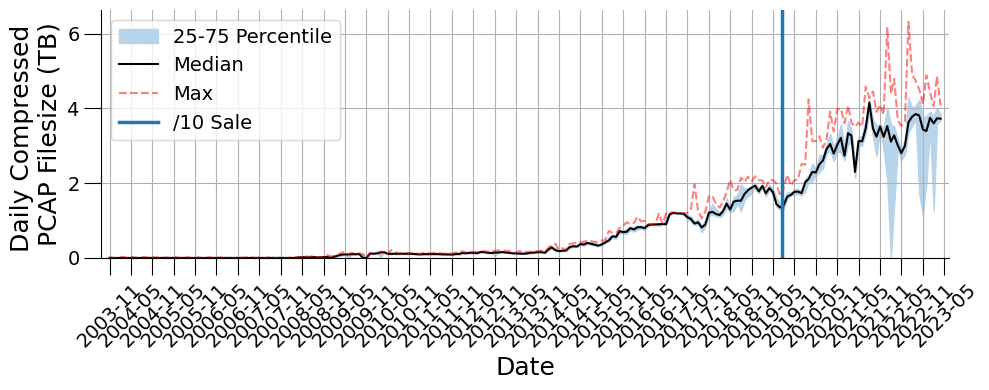

In [10]:
f, ax = plt.subplots(
    1,1, figsize=(10, 4), 
    constrained_layout=True, 
    squeeze=False,
    sharex=True, 
    sharey=True
)

xs = np.arange(len(daily_median_fs))

colors = plt.cm.Blues(np.linspace(0.3, 0.8, 4))
color = colors[0]
# for lower, upper, color in zip(np.arange(0.25, 0.5, 0.75), np.arange(0.75, 0.5, -0.25), colors):
ax[0][0].fill_between(daily_median_fs.index, 
                      daily_25q_fs.values, 
                      daily_75q_fs.values,
                      color=color, 
                      label=fr'25-75 Percentile')
    
ax[0][0].plot(daily_median_fs.index.values, daily_median_fs.values, color='black', lw=1.5, label='Median')
ax[0][0].plot(daily_max_fs.index.values, daily_max_fs.values, color='red', alpha=0.5, lw=1.5, linestyle='--', label='Max')
ax[0][0].axvline(datetime(2019,7,18), label='/10 Sale', linewidth=2.5)

### X-Axis
ax[0][0].set_xlabel('Date', fontsize=18)
ax[0][0].set_ylabel('Daily Compressed \nPCAP Filesize (TB)', fontsize=18)
ax[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax[0][0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax[0][0].tick_params(axis='x', rotation=45, size=12, labelsize=14)

### Y-Axis
ax[0][0].set_ylim(ymin=0)
# ax[0][0].yaxis.set_major_locator(ticker.MultipleLocator(50))
ax[0][0].tick_params(axis='y', size=12, labelsize=14)

ax[0][0].margins(x=0.01) # remove start to end
ax[0][0].legend(fontsize=14, loc='upper left')
ax[0][0].grid(which="major")

for sp in ['top', 'right']:
    ax[0][0].spines[sp].set_visible(False)

# plt.title('IBR Traffic Volumes Received at a /_ Network Telescope', fontsize=22.5)
plt.tight_layout()
# plt.savefig('./traffic_growth.pdf', format='pdf')
plt.show()